### Homework 3

Modern Stellar Astrophysics <br>
Melissa Ness <br>
November 13th 2018 <br>
Yasmeen Asali

In [79]:
import astropy.io.fits as fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from astropy.modeling.functional_models import Gaussian1D, Lorentz1D, Voigt1D
%matplotlib inline

### Problem 1

TBD! 

### Problem 2

**Part a)**

Downloading the data

In [25]:
data = fits.open("aspcapStar-r8-l31c.2-2M03343803+7133452.fits")

In [247]:
flux_spec = data[1].data
err_spec = data[2].data

Now, we have to generate a wavelength grid in order to view the spectrum using the datamodel ([source](https://data.sdss.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/LOCATION_ID/aspcapStar.html)).

In [27]:
nwave = data[1].header['naxis1'] #Number of wavelengths
crval = data[1].header['crval1'] #Start log10(wavelength) 
cdelt = data[1].header['cdelt1'] #Dispersion in log10(wavelength) 

print(nwave, crval, cdelt)

8575 4.179 6e-06


In [28]:
end = crval + (nwave*cdelt)
print(end)

4.23045


In [29]:
def wavelength(value):
    return 10**value

In [30]:
grid = np.arange(crval, end, cdelt)
wave_grid = wavelength(grid)

(0, 1.2273699998855592)

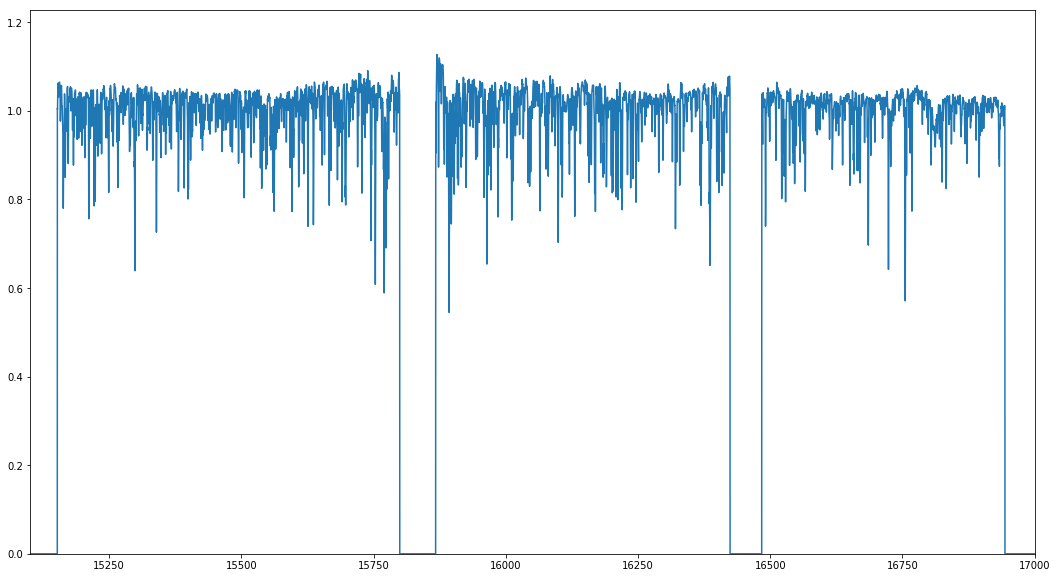

In [8]:
plt.figure(figsize = (18,10))
plt.plot(wave_grid, flux_spec)
plt.xlim(min(wave_grid), max(wave_grid))
plt.ylim(0, max(flux_spec)+0.1)

The next step is isolating the absorption line around 15523.9 Angstroms and finding a best fit model to it, then using $\chi^{2}$ minimization to find the best fit parameters.

(0.9, 1.1)

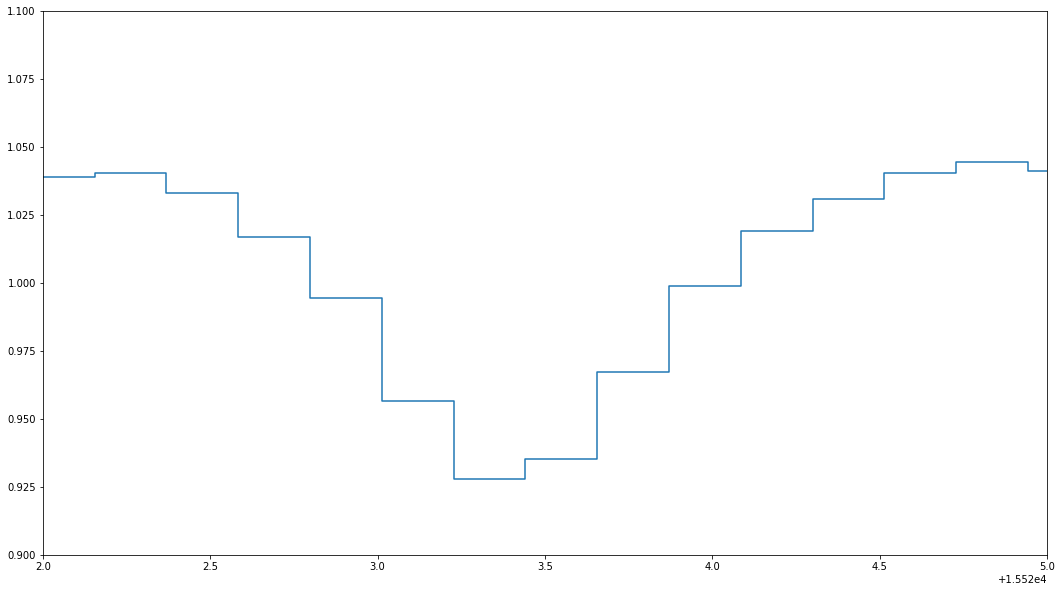

In [9]:
plt.figure(figsize = (18,10))
plt.step(wave_grid, flux_spec)
plt.xlim(15522, 15525)
plt.ylim(0.9, 1.1)

So here's the absorption line we are trying to study. Let's cut the data down to just those portions and try to plot some Guassian, Lorentz, and Voigt fits. 

Starting with Guassian:

In [248]:
abs_idx = np.where([15522 < i < 15525 for i in wave_grid])[0]
abs_flux = flux_spec[abs_idx]
abs_flux_err = err_spec[abs_idx]
abs_wave_grid = wave_grid[abs_idx]

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(15522.15443286021, 15524.942487572132)

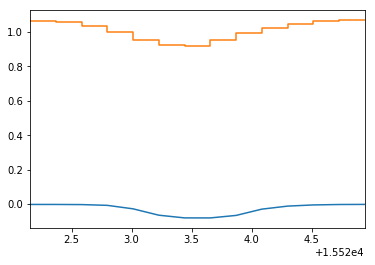

In [255]:
def gaussian(x, a, mean, sigma):
    return a * np.exp(-((x - mean)**2 / (2 * sigma**2)))

peak = min(abs_flux) #instead of mean
sigma = np.std(abs_flux)

popt, pcov = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[-0.08, peak, sigma])

plt.figure()
plt.plot(abs_wave_grid, gaussian(abs_flux, *popt), label='fit')
plt.step(abs_wave_grid, abs_flux)
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

Let's add an offset so the curves match! 

In [256]:
offset = np.mean(abs_flux) - np.mean(gaussian(abs_flux, *popt))

(15522.15443286021, 15524.942487572132)

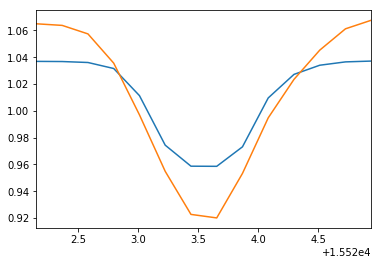

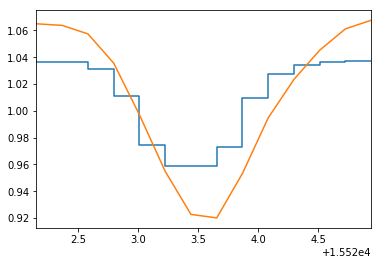

In [257]:
plt.figure()
plt.plot(abs_wave_grid, gaussian(abs_flux, *popt)+offset, label='fit')
plt.plot(abs_wave_grid, abs_flux)
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

plt.figure()
plt.step(abs_wave_grid, gaussian(abs_flux, *popt)+offset, label='fit')
plt.plot(abs_wave_grid, abs_flux)
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))


Another way we can do this fit is by flipping the graph then fitting a gaussian. Let's try that since it might work better:

(0, 0.15)

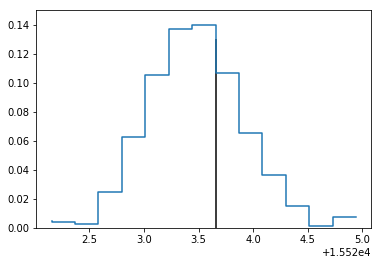

In [259]:
#Define a continuum region greater than 1.039 by looking at values
#Added a verticle line at the peak

cont_region_idx = np.where(abs_flux>1.039)[0]
cont_region = abs_flux[cont_region_idx]

zero_val = np.mean(cont_region)
zero_norm_flux = abs_flux - zero_val
flux_up = abs(zero_norm_flux)

peak_up_idx = np.argmax(flux_up)
peak_up = abs_wave_grid[peak_up_idx]

plt.figure()
plt.step(abs_wave_grid, flux_up)
plt.vlines(peak_up, 0, 0.13)
plt.ylim(0, 0.15)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(15522.15443286021, 15524.942487572132)

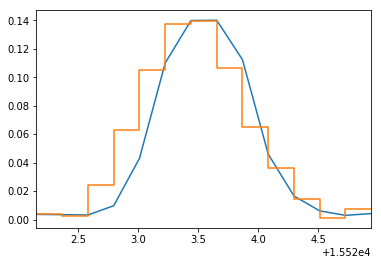

In [261]:
peak = max(flux_up)
sigma = np.std(flux_up)

popt, pcov = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma])

plt.figure()
plt.plot(abs_wave_grid, gaussian(flux_up, *popt), label='fit')
plt.step(abs_wave_grid, flux_up)
#plt.plot(abs_wave_grid, flux_up)
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

We could also try to fit a Lorentz or Voigt profile, but it looks like a guassian fits pretty well so let's go with that! 

Another thing I would've liked to do is use astropy's model fitting software which has Gaussian1D, Lorentz1D, Voigt1D packages, but it was a little complicated to figure out how to run them.

Nevertheless! We move on to a $\chi^{2}$ minimization! 

In [246]:
def chi_squared(data, model, error):
    chi_sq = (data - model)**2 / error**2
    sum_chi_sq = np.sum(chi_sq) 
    return sum_chi_sq

In [262]:
popt1, pcov1 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.18, peak, sigma])
model1 = gaussian(flux_up, *popt1)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [278]:
popt2, pcov2 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma])
model2 = gaussian(flux_up, *popt2)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [264]:
popt3, pcov3 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.10, peak, sigma])
model3 = gaussian(flux_up, *popt3)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [279]:
fit1 = chi_squared(flux_up, model1, abs_flux_err) 
fit2 = chi_squared(flux_up, model2, abs_flux_err)
fit3 = chi_squared(flux_up, model3, abs_flux_err)

In [280]:
print(fit1, fit2, fit3)

268.2412 61.55133 300.81302


(15522.15443286021, 15524.942487572132)

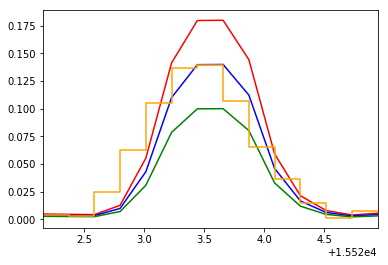

In [267]:
plt.figure()
plt.plot(abs_wave_grid, model1, color='red')
plt.plot(abs_wave_grid, model2, color='blue')
plt.plot(abs_wave_grid, model3, color='green')
plt.step(abs_wave_grid, flux_up, color='orange')
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

Our optimized $\chi^{2}$ is the second model, which has an amplitude of 0.14. We can see this both on the actual graph as well as with the fact our minimum value of $\chi^{2}$ corresponds to the second model. This minimum value is 61 which is still not very good. Maybe we can do better! Another parameter we can fit is the standard deviation, and we can use model 2 as a basis for checking different values of standard deviation.

Let's perturbe sigma by some small value. In order to determine roughly the magnitude of this small perturbation, lets look at sigma.

In [281]:
print(sigma)

0.049987465


So we can try perturbing by 0.005

In [282]:
popt21, pcov21 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma-0.005])
model21 = gaussian(flux_up, *popt21)

popt22, pcov22 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma])
model22 = gaussian(flux_up, *popt22)

popt23, pcov23 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma+0.005])
model23 = gaussian(flux_up, *popt23)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [283]:
fit21 = chi_squared(flux_up, model21, abs_flux_err) 
fit22 = chi_squared(flux_up, model22, abs_flux_err)
fit23 = chi_squared(flux_up, model23, abs_flux_err)

In [284]:
print(fit21, fit22, fit23)

123.29164 61.55133 27.840847


(15522.15443286021, 15524.942487572132)

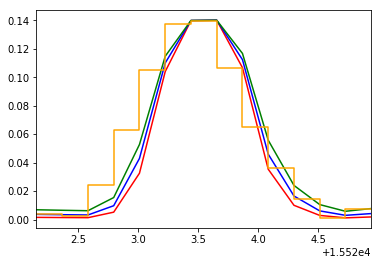

In [285]:
plt.figure()
plt.plot(abs_wave_grid, model21, color='red')
plt.plot(abs_wave_grid, model22, color='blue')
plt.plot(abs_wave_grid, model23, color='green')
plt.step(abs_wave_grid, flux_up, color='orange')
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

We have a winner! It's the third model for standard deviation (perturbing sigma by positive 0.005. What if we try perturbing it again in this direction to see if the fit gets better or worse. 

In [294]:
popt231, pcov231 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma+0.0075])
model231 = gaussian(flux_up, *popt231)

popt232, pcov232 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma+0.008])
model232 = gaussian(flux_up, *popt232)

popt233, pcov233 = curve_fit(gaussian, abs_wave_grid, abs_flux, p0=[0.14, peak, sigma+0.0085])
model233 = gaussian(flux_up, *popt233)

fit231 = chi_squared(flux_up, model231, abs_flux_err) 
fit232 = chi_squared(flux_up, model232, abs_flux_err)
fit233 = chi_squared(flux_up, model233, abs_flux_err)

print(fit231, fit232, fit233)

22.6166 22.54719 22.807766


/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Just by fitting the amplitude and the standard deviation, the best $\chi^{2}$ fit it seems we can get has a minimum value of $\chi^{2} = 22.54$. This isn't amazing, and ideally it would be 1, but visually the fit looks pretty good! 

(15522.15443286021, 15524.942487572132)

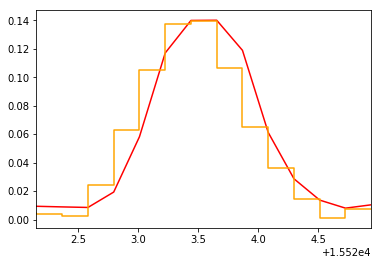

In [295]:
plt.figure()
plt.plot(abs_wave_grid, model232, color='red')
plt.step(abs_wave_grid, flux_up, color='orange')
plt.xlim(min(abs_wave_grid), max(abs_wave_grid))

** Part b) **

Now we have to want to isolate one pixel from many spectra and plot its logg, metallicity, and temperature. Let's start by opening the DR14 file with these parameters

In [162]:
hdu = fits.open('allStar-l31c.2.fits')

spec_data = hdu[1].data

APOGEE_ID = spec_data["APOGEE_ID"]
T_eff = spec_data['TEFF']
Fe_H = spec_data['FE_H']
logg = spec_data['LOGG']

Let's start by identifying the exact wavelength where the feature is centered

In [175]:
onestar_data = fits.open("APOGEE_spectra/aspcapStar-r8-l31c.2-2M16410648+3628136.fits")
onestar_flux = onestar_data[1].data

(0.8, 1.1)

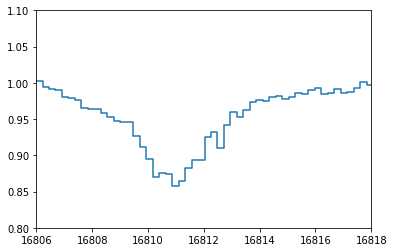

In [176]:
plt.step(wave_grid, onestar_flux)
plt.xlim(16806, 16818)
plt.ylim(0.8, 1.1)

In [177]:
pix_idxs = np.where([16806 < i < 16818 for i in wave_grid])[0]
pixs = onestar_flux[pix_idxs]
wave = wave_grid[pix_idxs]
min_pix_idx = np.argmin(pixs)
min_pix = pixs[min_pix_idx]
pix_wave = wave[min_pix_idx]

print("check if", min(pixs), "equals", min_pix)
print("so the center of the feature is", pix_wave)

check if 0.858076 equals 0.858076
so the center of the feature is 16811.094908135547


If you run the above code on three or four of the different spectra, they all have the absorption feature at slightly different locations. So I'm gonna assume you want us to take the data from the center of the absorption feature for each spectra. 

Next we want to open the ~400 APOGEE spectra, which we can do with a loop. I downloaded them from online and moved them into one directory, then wrote a bash script to make a text file containing all of the names of the spectra files within the directory. In python we can convert the contents of this file to a list

In [143]:
apogee_spec_list = [line.rstrip('\n') for line in open('spectra_list.txt')]

In [144]:
#let's first isolate which indicies corresponding to the ID
ID = apogee_spec_list[2][21:39]

#note, some IDs correspond to more than one row of data 
#we can ignore this and just take one of the two data points
idx = np.where([ID==i for i in APOGEE_ID])[0]

print("The ID:", ID ,'\n'
      "corresponds to two rows of data", APOGEE_ID[idx], '\n'
      "with different temperature values", T_eff[idx])
print("Ignore the second row of data")

The ID: 2M00454489+8504180 
corresponds to two rows of data ['2M00454489+8504180' '2M00454489+8504180'] 
with different temperature values [5006.4155 4981.9287]
Ignore the second row of data


In [163]:
pix_16810 = []
for file in apogee_spec_list:
    ID = str(file[21:39])
    filename = "APOGEE_spectra/" + str(file)
    data = fits.open(filename)
    flux = data[1].data
    
    pix_idxs = np.where([16806 < i < 16818 for i in wave_grid])[0]
    pixs= flux[pix_idxs]
    wave = wave_grid[pix_idxs]
    min_pix_idx = np.argmin(pixs)
    min_pix_flux = pixs[min_pix_idx]
    pix_wave = wave[min_pix_idx]
    
    #just in case
    APOGEE_ID = spec_data["APOGEE_ID"]
    T_eff = spec_data['TEFF']
    Fe_H = spec_data['FE_H']
    logg = spec_data['LOGG']

    index = np.where([ID==i for i in APOGEE_ID])[0]
    T_eff_val = T_eff[index[0]]
    Fe_H_val = Fe_H[index[0]]
    logg_val = logg[index[0]]
    pix_info = [min_pix_flux, T_eff_val, logg_val, Fe_H_val, ID]
    pix_16810.append(pix_info)

In [189]:
flux16810_lst = [item[0] for item in pix_16810]
temp16810_lst = [item[1] for item in pix_16810]
logg16810_lst = [item[2] for item in pix_16810]
metal16810_lst = [item[3] for item in pix_16810]

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.7, 1.1)

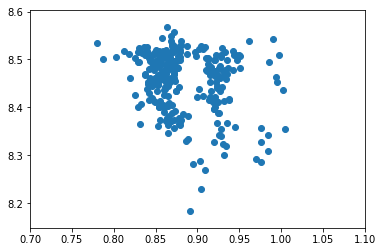

In [240]:
plt.scatter(flux16810_lst, np.log(temp16810_lst))
plt.xlim(0.70, 1.1)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.7, 1.1)

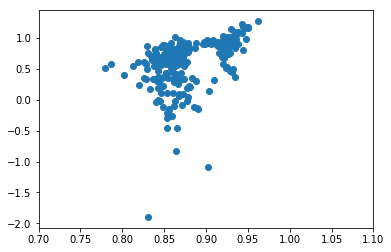

In [241]:
plt.scatter(flux16810_lst, np.log(logg16810_lst))
plt.xlim(0.7, 1.1)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.7, 1.1)

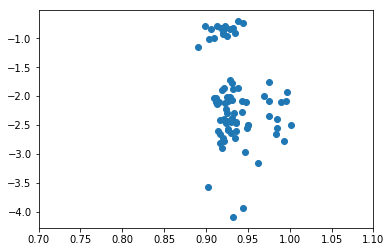

In [242]:
plt.scatter(flux16810_lst, np.log(metal16810_lst))
plt.xlim(0.7, 1.1)

So we have three graphs, but we are getting some pretty crazy values for temperature, logg, and metallicity. There are clearly some bas stars in this dataset, for example the minimum value for temperature (pinted below) is -9999. 

This is pretty weird because that data matched an APOGEE spectra, so I don't realy understand how APOGEE can measure a precise spectra but fail to measure values like temperature. 

In [236]:
print(min(temp16810_lst))

-9999.0


This could be improved by taking quality cuts of the APOGEE allStar file. But that's a task for another day when I have some more time :). 

Let's do the same thing for feature by 15339, starting with identifing an appropriate range for the feature. 

(0.8, 1.1)

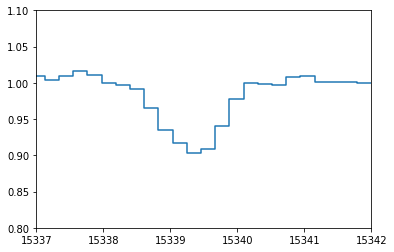

In [193]:
plt.step(wave_grid, onestar_flux)
plt.xlim(15337, 15342)
plt.ylim(0.8, 1.1)

In [194]:
pix_15339 = []
for file in apogee_spec_list:
    ID = str(file[21:39])
    filename = "APOGEE_spectra/" + str(file)
    data = fits.open(filename)
    flux = data[1].data
    
    pix_idxs = np.where([15337 < i < 15342 for i in wave_grid])[0]
    pixs= flux[pix_idxs]
    wave = wave_grid[pix_idxs]
    min_pix_idx = np.argmin(pixs)
    min_pix_flux = pixs[min_pix_idx]
    pix_wave = wave[min_pix_idx]
    
    APOGEE_ID = spec_data["APOGEE_ID"]
    T_eff = spec_data['TEFF']
    Fe_H = spec_data['FE_H']
    logg = spec_data['LOGG']

    index = np.where([ID==i for i in APOGEE_ID])[0]
    T_eff_val = T_eff[index[0]]
    Fe_H_val = Fe_H[index[0]]
    logg_val = logg[index[0]]
    pix_info = [min_pix_flux, T_eff_val, logg_val, Fe_H_val, ID]
    pix_15339.append(pix_info)

In [195]:
flux15339_lst = [item[0] for item in pix_15339]
temp15339_lst = [item[1] for item in pix_15339]
logg15339_lst = [item[2] for item in pix_15339]
metal15339_lst = [item[3] for item in pix_15339]

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.4, 1.05)

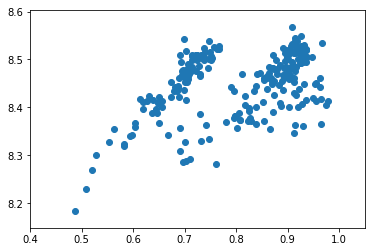

In [200]:
plt.scatter(flux15339_lst, np.log(temp15339_lst))
plt.xlim(0.4, 1.05)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.4, 1.05)

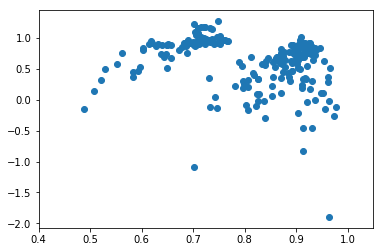

In [202]:
plt.scatter(flux15339_lst, np.log(logg15339_lst))
plt.xlim(0.4, 1.05)

/Users/yasmeenasali/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(0.4, 1.05)

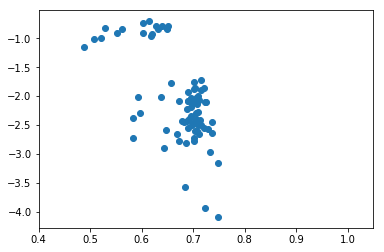

In [201]:
plt.scatter(flux15339_lst, np.log(metal15339_lst))
plt.xlim(0.4, 1.05)

To isolate a continuum pixel, we can take the absolute value of the difference between 1 and the flux of a given pixel. This absolute value will give us the magnitude of the deviation from the continuum line. So taking the minimum value of this will give us the "best" continuum pixel for each spectrum.

In [235]:
pix_continuum = []
for file in apogee_spec_list:
    ID = str(file[21:39])
    filename = "APOGEE_spectra/" + str(file)
    data = fits.open(filename)
    flux = data[1].data
    
    dev_lst = []
    for i in flux:
        deviation = abs(1-i)
        dev_lst.append(deviation)
        
    cont_pix_idx = np.where([min(dev_lst)])[0]
    continuum_pixel= flux[cont_pix_idx]
    
    APOGEE_ID = spec_data["APOGEE_ID"]
    T_eff = spec_data['TEFF']
    Fe_H = spec_data['FE_H']
    logg = spec_data['LOGG']

    index = np.where([ID==i for i in APOGEE_ID])[0]
    T_eff_val = T_eff[index[0]]
    Fe_H_val = Fe_H[index[0]]
    logg_val = logg[index[0]]
    pix_info = [continuum_pixel, T_eff_val, logg_val, Fe_H_val, ID]
    pix_continuum.append(pix_info)
    
%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 48.9 µs


In [243]:
cont_flux_lst = [item[0] for item in pix_continuum]
cont_temp_lst = [item[1] for item in pix_continuum]
cont_logg_lst = [item[2] for item in pix_continuum]
cont_metal_lst = [item[3] for item in pix_continuum]

In [245]:
#plt.scatter(cont_flux_lst, np.log(cont_temp_lst))

I don't know why I can't plot this! I spent a while trying to figure how to get the code to output something meaningful and couldn't figure it out, so I'll take a look again another day. (If you trying running the plot line above you get a bunch of errors, and if you check the contents of cont_flux_list its all zeroes). 

** Part e) **

Looking at the graphs of the absorption features at 16810 and 15339 angstroms I can't really see any correlations with temperature, logg and $[\frac{Fe}{H}]$. It seems like the pixels at the centers of absorption features don't really carry that much information that is significant with respect to these parameters (maybe the continuum pixels do?). 

Note: some of the stars in APOGEE have bad or weird data points. 

### Problem 3

** Part a) **

We can solve for the radius of the star using the $n=1$ solution:

$$ \theta = \frac{\sin{\zeta}}{\zeta} $$

We can substitute:

$$ \zeta = \frac{r}{\alpha} $$

Where $ \alpha $ at $n = 1$ evalutes to 

$$ \alpha = \left( \frac{(n+1)K}{4\pi G \rho^{\frac{n-1}{n}}} \right) ^{1/2} = \left( \frac{K}{2\pi G} \right) ^{1/2}$$

Plugging this into theta we find

$$ \theta = \sin{\frac{r}{\left(\frac{K}{2\pi G}\right)^{1/2}}} \cdot \frac{1}{\frac{r}{\left(\frac{K}{2\pi G}\right)^{1/2}}} $$

At $n=1$, $ \theta = \frac{\rho}{\rho_{c}} $ and at the surface of the star, where $ r= R $, $ \theta = 0$. So plugging in these values:

$$ 0 = \sin{\frac{R}{\left(\frac{K}{2\pi G}\right)^{1/2}}} \cdot \frac{1}{\frac{R}{\left(\frac{K}{2\pi G}\right)^{1/2}}} $$

$$ 0 = \sin{\frac{R}{\left(\frac{K}{2\pi G}\right)^{1/2}}}$$

The first solution is $\pi$, so lets take that

$$ \pi = \frac{R}{\left(\frac{K}{2\pi G}\right)^{1/2}}$$

Rearranging,

$$ \boxed{ R = \pi \left(\frac{K}{2\pi G}\right)^{1/2} }$$

** Part b) **

Starting from the above equation and rearranging for $K$,

$$ R = \pi \left(\frac{K}{2\pi G}\right)^{1/2} $$

$$ K = \left(\frac{R}{\pi}\right)^{2} {2\pi G} $$

$$ K = \frac{2G R^{2}}{\pi} $$

In [231]:
Grav_const = 6.67408e-11 * u.m**3 * u.kg**(-1) * u.s**(-2)
R_sun = 6.9599e8 * u.m
K = (2 * Grav_const * R_sun**2) / (np.pi)
print(K)

20581524.030874196 m5 / (kg s2)


So our final value for $K$ is: 

$$ \boxed{ K = 2.05 \cdot 10^{7} \frac{m^{5}}{kg s^{2}} } $$

** Part c) **

For an isothermal star, temperature is constant so pressure and volume must be inversely propotional. If we consider the core of this star, which is a small volume, the constant temperature implies that the core pressure must be extremely high. If $P \propto \rho$ then a high pressure implies a hig density. Since we are considering a polytropic star, a high density implies a large $ n $. In fact, if you consider the case where $ n $ will go to infinity the radius must also approach infinity so such a star cannot exist. 

### Problem 5

** Part a) **

The mean atomic mass of a material $\mu_{I}$ is defined as the sum of mass fraction of all the elements over their atomic mass:

$$ \frac{1}{\mu_{I}} = \sum_{i} \frac{X_{i}}{\mathcal{A_{i}}} $$

Since there are only two elements (hydrogen and helium, we can express it like so: 

$$ \frac{1}{\mu_{I}} = \frac{X_{H}}{\mathcal{A_{H}}} + \frac{X_{He}}{\mathcal{A_{He}}} $$

$$ \frac{1}{\mu_{I}} = \frac{0.75}{1} + \frac{0.25}{4} $$

In [74]:
inverse_mu_i = (0.75) + (0.25 / 4)
mu_i = 1 / inverse_mu_i
print(mu_i)

1.2307692307692308


So we get the value $\boxed{\mu_{I} = 1.23}$.

The formula for $\mu_{e}$ is:

$$ \frac{1}{\mu_{e}} = \sum_{i}X_{i} \frac{Z_{i}}{\mathcal{A_{i}}} $$

Which we can seperate out into:

$$ \frac{1}{\mu_{e}} = X_{H}\frac{Z_{H}}{\mathcal{A_{H}}} + X_{He}\frac{Z_{He}}{\mathcal{A_{He}}} $$

$$ \frac{1}{\mu_{e}} = 0.75\frac{1}{1} + 0.25\frac{2}{4} $$

In [75]:
inverse_mu_e = (0.75) + 0.25*(2/4)
mu_e = 1 / inverse_mu_e
print(mu_e)

1.1428571428571428


So we get the value $\boxed{\mu_{e} = 1.14}$. 

In order to calcuate the mean molecular weight $\mu$ we add the inverse of the two above values: 

$$ \frac{1}{\mu}= \frac{1}{\mu_{e}} + \frac{1}{\mu_{I}} $$

In [78]:
inverse_mu = inverse_mu_e + inverse_mu_i
mu = 1 / inverse_mu
print(mu)

0.5925925925925926


So our final value for the mean molecular weight of this particular gas is $\boxed{\mu = 0.59}$. 

** Part b) **

The pressure in the ideal gas zone and in the non-relativistic degenerate zone are given by the following equations:

$$ P_{I} = \frac{\mathcal{R}}{\mu_{I}} \rho T $$

$$ P_{e, deg} = \frac{h^{2}}{20m_{e}} \left(\frac{3}{\pi}\right)^{2/3}\left(\frac{\rho}{m_{H}\mu_{e}}\right)^{5/3} $$
 

We can equate the pressure equations like so: 

$$ K_{0} \rho T = K_{1} \rho^{5/3} $$

So we can see that immediately that

$$ K_{0} = \frac{\mathcal{R}}{\mu_{I}} $$

$$ K_{1} = \frac{h^{2}}{20m_{e}} \left(\frac{3}{\pi}\right)^{2/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{5/3} $$

Solving for $\rho$ in terms of $T$ gives us

$$ \rho = \left(\frac{K_{0}}{K_{1}} T\right)^{3/2} $$

$$ \log\rho = \log\left(\frac{K_{0}}{K_{1}} T\right)^{3/2} $$

$$ \log\rho = \frac{3}{2}\log\left(\frac{K_{0}}{K_{1}} T\right) $$

$$ \log\rho = \frac{3}{2}\log T + \frac{3}{2}\log\left(\frac{K_{0}}{K_{1}}\right) $$

We can express the last term $ \frac{3}{2}\log\left(\frac{K_{0}}{K_{1}}\right) $ as a constant $ K $ giving us a final equation:

$$ \log\rho = \frac{3}{2}\log T + K $$

where $K$ can be fullly expressed as 

$$ K = \frac{3}{2}\Bigg[ \log\left(\frac{\mathcal{R}}{\mu_{I}}\right) - \log\bigg(\frac{h^{2}}{20m_{e}} \left(\frac{3}{\pi}\right)^{2/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{5/3}\bigg) \Bigg]$$

$$ K = \frac{3}{2} \log\left(\frac{\mathcal{R}}{\mu_{I}}\right) -\log\bigg[ \frac{3}{\pi} \left(\frac{h^{2}}{20m_{e}}\right)^{2/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{5/2}\bigg] $$

So

$$ \log\rho = \frac{3}{2}\log T + \frac{3}{2} \log\left(\frac{\mathcal{R}}{\mu_{I}}\right) -\log\bigg[ \frac{3}{\pi} \left(\frac{h^{2}}{20m_{e}}\right)^{2/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{5/2}\bigg] $$

Now we can input numerical values into the easier version of the $K$ equation because values are given in the book. Using this equation:

$$ K = \frac{3}{2}\log\left(\frac{K_{0}}{K_{1}}\right) $$

Where the constants are defined as 

$$ K_{0} = \frac{\mathcal{R}}{\mu_{I}} $$ 

$$ K_{1} = \frac{K_{1}^{'}}{\mu_{e}^{5/3}} $$

In [88]:
R = 8.314e7
K_0 = R * inverse_mu_i
K_1_prime = 1e13
K_1 = K_1_prime * inverse_mu_e**(5/3)
ideal_deg_boundary = (3/2) * np.log10(K_0 / K_1)
print(ideal_deg_boundary)

-7.610570047824122


So our final equation is 

$$ \log\rho = \frac{3}{2}\log T - 7.61 $$

And our final values are 

$$\boxed{constant = -7.61}$$

$$\boxed{\alpha = \frac{3}{2}} $$

** Part c) **

Now we can do the same exercise to calculate the boundary between the non-relativistic and relativistic degenerate zones. Using the same non-relativistic pressure equation from above, we can equate it to the following:

$$ P_{e, r, deg} = \frac{hc}{8} \left(\frac{3}{\pi}\right)^{1/3}\left(\frac{\rho}{m_{H}\mu_{e}}\right)^{4/3} $$

Again we can keep $K_{1}$ the same and use the following for $K_{2}$

$$ K_{2} = \frac{hc}{8} \left(\frac{3}{\pi}\right)^{1/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{4/3} $$

So we equate the two pressure equations to find

$$ K_{1} \rho^{5/3} = K_{2} \rho^{4/3} $$

$$ \rho = \left(\frac{K_{2}}{K_{1}}\right)^{3} $$

We can express $ K = \left(\frac{K_{2}}{K_{1}}\right) $ giving us the express:

$$ \log\rho = 3\log K $$

Where $K$ explicity equals

$$ K = \frac{ \frac{hc}{8} \left(\frac{3}{\pi}\right)^{1/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{4/3} } { \frac{h^{2}}{20m_{e}} \left(\frac{3}{\pi}\right)^{2/3}\left(\frac{1}{m_{H}\mu_{e}}\right)^{5/3} } $$

$$ K = \frac{5cm_{e}}{2} \left(\frac{m_{H}\mu_{e}\pi}{3}\right)^{1/3} $$

So we can simplfy the equation further to 

$$ \log\rho = 3\log \Bigg[ \frac{5cm_{e}}{2} \left(\frac{m_{H}\mu_{e}\pi}{3}\right)^{1/3} \Bigg] $$

$$ \log\rho = \log \Bigg[ \left(\frac{5cm_{e}}{2}\right)^{3} \frac{m_{H}\mu_{e}\pi}{3} \Bigg] $$

Again, to evaluate the numerical answer we can use the constants provided in the book so let $ K_{1} $ be the same as before and 

$$ K_{2} = \frac{K_{2}^{'}}{\mu_{e}^{4/3}} $$

And it will be easiest to evaluate numerically using this formula:

$$ \log\rho = \log\left(\frac{K_{2}}{K_{1}}\right)^{3} $$

In [87]:
K_2_prime = 1.24e15
K_2 = K_2_prime * inverse_mu_e**(4/3)
deg_reldeg_boundary = 3 * np.log10(K_2 / K_1)
print(deg_reldeg_boundary)

6.338257002464393


So the final value for the constant is

$$ \boxed{constant = 6.338} $$

** Part d) ** 

For the rest of these problems, I'm not going to explain what K equals in terms of more fundamental constants because it is unneccesary. So in order to solve for the boundary between the relativistic degenerate and ideal zones use the following equations:

$$ P_{I} = P_{e, r, deg} $$

$$ K_{0} \rho T = \frac{K_{2}^{'}}{\mu_{e}^{4/3}} \rho^{4/3} $$

$$  \rho^{1/3} =   \frac{\mu_{e}^{4/3} K_{0}  T} {K_{2}^{'}}  $$

$$ \log \rho^{1/3} = \log \frac{\mu_{e}^{4/3} K_{0}  T} {K_{2}^{'}}$$ 

$$ \log \rho = 3 \log \frac{\mu_{e}^{4/3} K_{0}  T} {K_{2}^{'}}$$ 

$$ \log \rho = 3 \log T + 3 \log \frac{\mu_{e}^{4/3} K_{0}} {K_{2}^{'}}$$

So we can solve for our constant

In [89]:
ideal_reldeg_boundary = 3 * np.log10((mu_e**(4/3) * K_0) / K_2_prime)
print(ideal_reldeg_boundary)

-21.559397098112633


So our final value is 

$$ \rho = 3\log T - 21.55 $$

And our final values are:
     
$$ \boxed{constant = -21.55} $$

$$ \boxed{\alpha = 3} $$

** Part e) **

In order to find the point where all three pressures are equal we can equate the two eqautions:

 $$ \frac{3}{2}\log T - 7.61 = \log \rho = 3\log T - 21.55 $$
 
 $$ 3\log T - \frac{3}{2}\log T = - 7.61 + 21.55 $$
 
 $$ \frac{3}{2}\log T = 13.94 $$
 
 Now we can solve for T

In [107]:
#instead of using approx constants from above used the values stored in variables

const = ideal_deg_boundary - ideal_reldeg_boundary
log_T =(2/3)*const
T = 10**log_T
print(T)

1991672989.0268373


Using $ \log T $ we can calculate $ \log \rho $

In [104]:
log_rho = 3*log_T + ideal_reldeg_boundary
rho = 10 ** log_rho
print(rho)

2178998.857142821


So our final values are

$$ \boxed{T = 1.99 \cdot 10^{9}} $$

$$ \boxed{\rho = 2.17 \cdot 10^{7}} $$

** Part f) **

We can find the boundary between the ideal gas law and radiation pressure using 

$$ P_{rad} = 10 P_{I} $$

We know $ P_{I} $ from above, and $ P_{rad}$ can be expressed as 

$$ P_{rad} = \frac{1}{3} a T^{4} $$

So we have 

$$ \frac{1}{3} a T^{4} = 10 K_{0} \rho T $$

$$ \rho = \frac{a}{30 K_{0}} T^{3} $$

$$ \log \rho = 3\log T + \log \frac{a}{30 K_{0}} $$

Solving for the constant, 

In [100]:
a = 7.5646e-15
rad_ideal_boundary = np.log10(a / (30 * K_0))
print(rad_ideal_boundary)

-23.42796867614529


So our final value is 

$$ \rho = 3\log T - 23.43 $$

And our final values are:
     
$$ \boxed{constant = -23.43} $$

$$ \boxed{\alpha = 3} $$

### Future Work (for the next two weeks) 

- problem 1
- quality cuts on APOGGEE allStar data
- trying to get and plot a sensible output for continuum pixel flux 
- finish problem 4

### Bonus: Problem 4

### FAILED GRAPHS

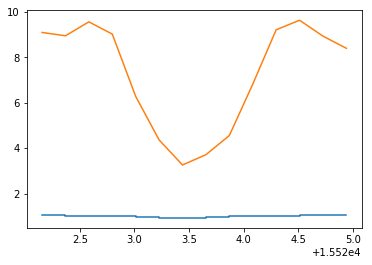

In [72]:
plt.figure()

gauss_fit = stats.gaussian_kde(abs_flux)
plt.step(abs_wave_grid, abs_flux)
plt.plot(abs_wave_grid, gauss_fit(abs_flux))